In [3]:
import torch
print(torch.version.cuda)  # 빌드된 CUDA 버전 확인
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


12.4
True
NVIDIA GeForce RTX 4090


In [92]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader as loader
import torchvision 
from torchvision import datasets, transforms, models
import torch.optim as optim

In [94]:
transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(        
        mean=(0.485, 0.456, 0.406),           # ImageNet 통계값
        std =(0.229, 0.224, 0.225))
])

train_data=datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data=datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader=loader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader=loader(test_data, batch_size=100,shuffle=True, num_workers=2)

device=torch.device("cuda"if torch.cuda.is_available()else"cpu")
print(device)
model=models.resnet18(pretrained=True)
model

Files already downloaded and verified
Files already downloaded and verified
cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
'''
for param in model.parameters():
    param.requires_grad=False
'''
for name,param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad=True
    else:
        param.requires_grad=False

In [98]:

num_ft=model.fc.in_features
model.fc=nn.Linear(num_ft, 10)
model=model.to(device)

criter=nn.CrossEntropyLoss()
#optimy=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimy=optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.0001, momentum=0.9
)
save_every = 2 
num_epoch=10

In [100]:
for epoch in range(num_epoch):
    total_L=0.0
    for data, target in train_loader:
        target=target.to(device)
        data=data.to(device)
        
        optimy.zero_grad()
        out=model(data)
        loss=criter(out,target)
        loss.backward()
        optimy.step()
        total_L+=loss.item()*data.size(0)

    if (epoch+1) % save_every == 0:
        torch.save({
            "epoch": epoch+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict()
        }, f"./checkpoints/cnn_epoch{epoch+1}.pth")
    print(f"Checkpoint saved: epoch {epoch+1}")

    evg_loss=total_L/len(train_data)
    print(f"[FeatureExt] Epoch {epoch+1}/{num_epoch}, Loss: {evg_loss:.4f}")

Checkpoint saved: epoch 1
[FeatureExt] Epoch 1/10, Loss: 1.4440
Checkpoint saved: epoch 2
[FeatureExt] Epoch 2/10, Loss: 0.7988
Checkpoint saved: epoch 3
[FeatureExt] Epoch 3/10, Loss: 0.6305
Checkpoint saved: epoch 4
[FeatureExt] Epoch 4/10, Loss: 0.5468
Checkpoint saved: epoch 5
[FeatureExt] Epoch 5/10, Loss: 0.4920
Checkpoint saved: epoch 6
[FeatureExt] Epoch 6/10, Loss: 0.4528
Checkpoint saved: epoch 7
[FeatureExt] Epoch 7/10, Loss: 0.4267
Checkpoint saved: epoch 8
[FeatureExt] Epoch 8/10, Loss: 0.4006
Checkpoint saved: epoch 9
[FeatureExt] Epoch 9/10, Loss: 0.3787
Checkpoint saved: epoch 10
[FeatureExt] Epoch 10/10, Loss: 0.3621


In [104]:
from sklearn.metrics import accuracy_score

results = {}

for lr, bs, mom in itertools.product([0.1, 0.01, 0.001], [32, 64], [0.9, 0.99]):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_data,  batch_size=bs, shuffle=False, num_workers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)

    # 학습 1 epoch (생략…)
    # 3) 1 에폭 학습 (예시)
    model.train()
    total_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_ds)
    print(f"lr={lr:>6}, bs={bs:>3}, mom={mom:.2f}  ->  Avg Loss: {avg_loss:.4f}")

    # 4) 결과 저장
    results[(lr, bs, mom)] = avg_loss
    # 평가
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            preds = model(x).argmax(1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(y.tolist())

    acc = accuracy_score(all_labels, all_preds)
    print(f"lr={lr:.3f}, bs={bs:>3}, mom={mom:.2f}  ->  Accuracy: {acc*100:5.2f}%")
    results[(lr, bs, mom)] = acc


lr=   0.1, bs= 32, mom=0.90  ->  Avg Loss: 0.1910
lr=0.100, bs= 32, mom=0.90  ->  Accuracy: 89.42%
lr=   0.1, bs= 32, mom=0.99  ->  Avg Loss: 0.3928
lr=0.100, bs= 32, mom=0.99  ->  Accuracy: 86.18%
lr=   0.1, bs= 64, mom=0.90  ->  Avg Loss: 0.1815
lr=0.100, bs= 64, mom=0.90  ->  Accuracy: 88.94%
lr=   0.1, bs= 64, mom=0.99  ->  Avg Loss: 0.1628
lr=0.100, bs= 64, mom=0.99  ->  Accuracy: 88.80%
lr=  0.01, bs= 32, mom=0.90  ->  Avg Loss: 0.0921
lr=0.010, bs= 32, mom=0.90  ->  Accuracy: 89.19%
lr=  0.01, bs= 32, mom=0.99  ->  Avg Loss: 0.0756
lr=0.010, bs= 32, mom=0.99  ->  Accuracy: 89.58%
lr=  0.01, bs= 64, mom=0.90  ->  Avg Loss: 0.0416
lr=0.010, bs= 64, mom=0.90  ->  Accuracy: 89.72%
lr=  0.01, bs= 64, mom=0.99  ->  Avg Loss: 0.0410
lr=0.010, bs= 64, mom=0.99  ->  Accuracy: 89.69%
lr= 0.001, bs= 32, mom=0.90  ->  Avg Loss: 0.0474
lr=0.001, bs= 32, mom=0.90  ->  Accuracy: 89.70%
lr= 0.001, bs= 32, mom=0.99  ->  Avg Loss: 0.0459
lr=0.001, bs= 32, mom=0.99  ->  Accuracy: 89.83%
lr= 0.001,

In [106]:
# (위에서 results 딕셔너리에 저장을 다 했다고 가정)

# 1) (lr, bs, mom), loss 튜플 리스트로 변환
items = list(results.items())

# 2) loss 기준 오름차순 정렬
items.sort(key=lambda x: x[1])

print("\n=== Hyperparameter Tuning Summary (by Loss) ===")
for (lr, bs, mom), loss in items:
    print(f"lr={lr:>6}, bs={bs:>3}, mom={mom:.2f}  ->  Avg Loss: {loss:.4f}")

# 3) 최고 성능 조합만 보고 싶으면
best_params, best_loss = items[0]
lr, bs, mom = best_params
print(f"\nBest setting: lr={lr}, bs={bs}, mom={mom} -> Loss={best_loss:.4f}")



=== Hyperparameter Tuning Summary (by Loss) ===
lr=   0.1, bs= 32, mom=0.99  ->  Avg Loss: 0.8618
lr=   0.1, bs= 64, mom=0.99  ->  Avg Loss: 0.8880
lr=   0.1, bs= 64, mom=0.90  ->  Avg Loss: 0.8894
lr=  0.01, bs= 32, mom=0.90  ->  Avg Loss: 0.8919
lr=   0.1, bs= 32, mom=0.90  ->  Avg Loss: 0.8942
lr=  0.01, bs= 32, mom=0.99  ->  Avg Loss: 0.8958
lr= 0.001, bs= 64, mom=0.90  ->  Avg Loss: 0.8963
lr=  0.01, bs= 64, mom=0.99  ->  Avg Loss: 0.8969
lr= 0.001, bs= 32, mom=0.90  ->  Avg Loss: 0.8970
lr=  0.01, bs= 64, mom=0.90  ->  Avg Loss: 0.8972
lr= 0.001, bs= 64, mom=0.99  ->  Avg Loss: 0.8978
lr= 0.001, bs= 32, mom=0.99  ->  Avg Loss: 0.8983

Best setting: lr=0.1, bs=32, mom=0.99 -> Loss=0.8618


In [83]:
model.eval()
correct=0.0
total=0.0
with torch.no_grad():
    for data, target in test_loader:
        data=data.to(device)
        target=target.to(device)
        out=model(data)
        _,pred=torch.max(out, 1)
        correct+=(pred==target).sum().item()
        total+=target.size(0)

print(f"[FeatureExt] Test Accuracy: {100*correct/total:.2f}%")

[FeatureExt] Test Accuracy: 87.21%


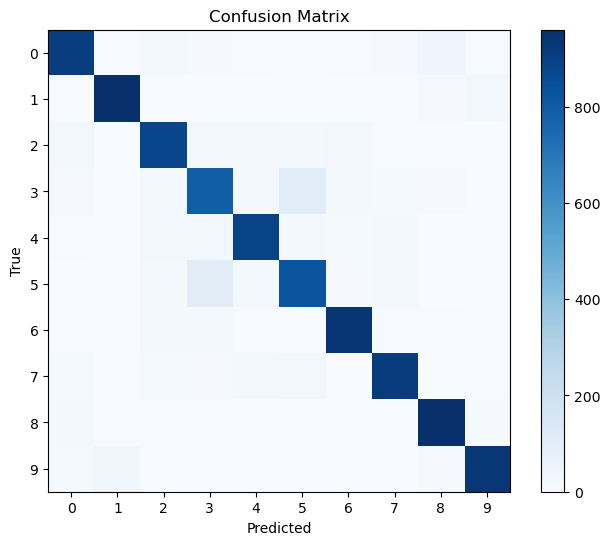

In [108]:
#3. Confusion Matrix 시각화

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 3.1 예측 수집
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3.2 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 3.3 히트맵 출력
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(10)
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# 1) 데이터 준비 (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize(224),                   # ResNet 입력 크기(224x224)로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(                    
        mean=(0.485, 0.456, 0.406),           # ImageNet 통계값
        std =(0.229, 0.224, 0.225)
    )
])
train_ds = datasets.CIFAR10("./data", train=True,  download=True, transform=transform)
test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=100, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) 사전 학습된 ResNet18 불러오기
model = models.resnet18(pretrained=True)

# 3) Feature Extraction 전략: 모든 파라미터를 freeze
for param in model.parameters():
    param.requires_grad = False

# 4) 마지막 FC 레이어를 CIFAR-10용으로 교체
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 클래스 수 = 10

model = model.to(device)

# 5) 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# 6) 학습 루프 (Feature Extraction)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_ds)
    print(f"[FeatureExt] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# 7) 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"[FeatureExt] Test Accuracy: {100*correct/total:.2f}%")


In [ ]:
#1. 체크포인트 저장/불러오기
if (epoch+1)%save_every==0:
    torch.

In [86]:
import torch

# 학습 루프 중에
if (epoch+1) % save_every == 0:
    torch.save({
        "epoch": epoch+1,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict()
    }, f"./checkpoints/cnn_epoch{epoch+1}.pth")
    print(f"Checkpoint saved: epoch {epoch+1}")


NameError: name 'save_every' is not defined

In [102]:
#2. 하이퍼파라미터 튜닝
import itertools

results = {}
for lr, bs, mom in itertools.product([0.1,0.01,0.001], [32,64], [0.9,0.99]):
    train_loader = loader(train_data, batch_size=bs, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)

    model.train()
    total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)

    results[(lr,bs,mom)] = total / len(train_ds)


KeyboardInterrupt: 